In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
import pyBigWig
import gget
import pysam

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
filepath = "filtered_data/clique1MBfiltered.csv"

df = pd.read_csv(filepath)
df['filterType'] = 'expanded'

print(f"{df.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(636130, 66)


In [4]:
# resolution = 100000 # 100kb scale
resolution = 1000000 # 1Mb scale
# resolution = 10000000 # 10Mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

newRows = []
matrices = {}

for cell in df['cell'].unique():
    
    tmp = df[(df['cell'] == cell)].reset_index(drop=True)
    cellBinned = binning.wholeGenomeBinData(tmp, bins, label1, label2)
    
    A = pcu.getHic(cellBinned, bins, label1, label2)
    print(f"{cell=} {A.shape=}")
    matrices[cell] = A
    newRows.append(cellBinned)
    
df = pd.concat(newRows, ignore_index=True)
print(f"{df.shape=}")
print('done.')

cell='run01' A.shape=(2724, 2724)
cell='run02' A.shape=(2724, 2724)
cell='run04' A.shape=(2724, 2724)
cell='run05' A.shape=(2724, 2724)
cell='run06' A.shape=(2724, 2724)
cell='run07' A.shape=(2724, 2724)
df.shape=(636130, 68)
done.


In [5]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)

filteredPoreCIndex = list(range(0, int(max(bins) / resolution)))
print(f"{len(filteredPoreCIndex)=}")

len(filteredPoreCIndex)=2724


In [6]:
filteredChromInfo.head()

,region,start,end,length
0,chr1,1,197,196
1,chr2,196,378,182
2,chr3,377,538,161
3,chr4,537,695,158
4,chr5,694,847,153


In [7]:
# load tads 
tad = pd.read_csv('F121_mESC_TADS.txt', sep='\t', header=None)
tad.columns = ['id', 'start', 'end', 'undef']
tad['phase'] = tad['id'].apply( lambda x: x.split("_")[0])
tad['chrom'] = tad['id'].apply( lambda x: x.split("_")[1])

print(f"{tad.shape=}")

tadChr2 = tad[(tad['chrom'] == '2') & (tad['phase'] == 'G1')].reset_index(drop=True)
print(f"{tadChr2.shape=}")


binStart = []
binEnd = []

for idx, row in tadChr2.iterrows():
    tadStart = binning.returnBin(row['start'], bins)
    tadEnd = binning.returnBin(row['end'], bins)
    
    binStart.append(tadStart)
    binEnd.append(tadEnd)
    
tadChr2['binStart'] = binStart
tadChr2['binEnd'] = binEnd
tadChr2['tadLen'] = tadChr2['binEnd'] - tadChr2['binStart']

tadChr2.head()

tad.shape=(4104, 6)
tadChr2.shape=(160, 6)


,id,start,end,undef,phase,chrom,binStart,binEnd,tadLen
0,G1_2,154413264,154595264,20,G1,2,153,153,0
1,G1_2,152671264,153584264,20,G1,2,151,152,1
2,G1_2,156370264,157570264,20,G1,2,155,156,1
3,G1_2,30076480,30354480,20,G1,2,29,29,0
4,G1_2,164950500,165729500,20,G1,2,163,164,1


In [8]:
chromosome = ['chr2']

chrom2 = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    A = np.where(A > 0, 1, 0)
    np.fill_diagonal(A, 1)
    return A
    

for runId in matrices.keys():
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    A = processMat(matrices[runId], ind)
    chrom2[runId] = A
    
    
print('done.')

done.


In [9]:
# build ensemble 

# ensemble = np.zeros((182, 182))

# for k, v in chrom2.items():
#     ensemble += v
    
# print('done')

ch.shape=(8200, 69)


(183.0, -1.0)

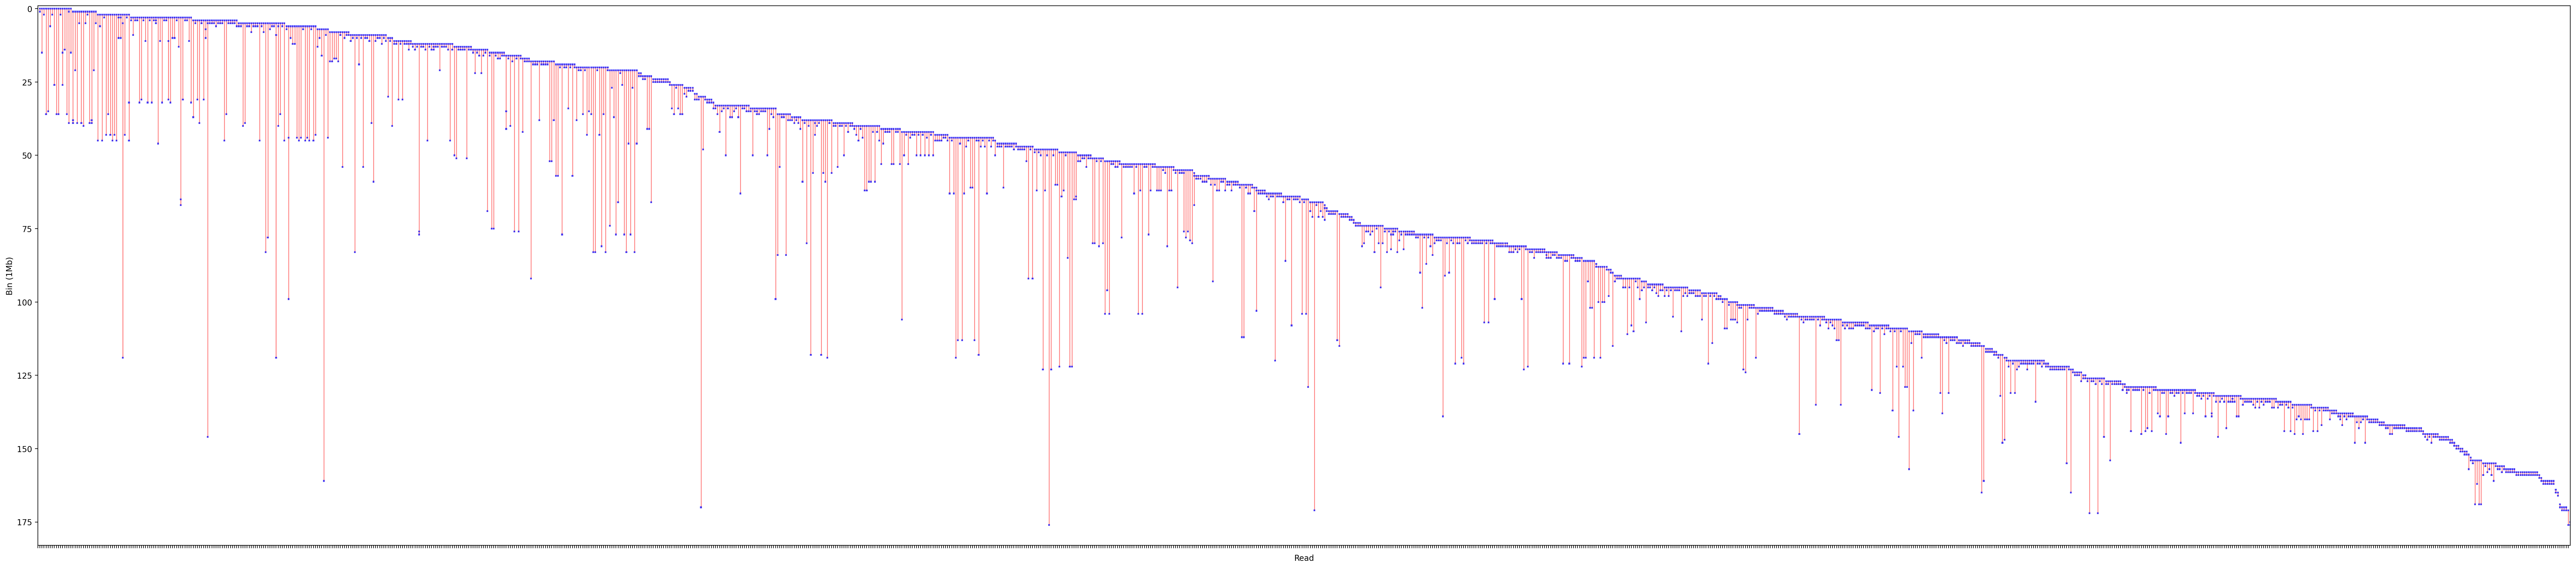

In [15]:
chrom = 2

ch = df[df['align1_chromosome_name'] == str(chrom)]
ch = ch[ch['align2_chromosome_name'] == str(chrom)]

ch['minPairBin'] = ch[['bin1', 'bin2']].min(axis=1)
ch = ch.sort_values(by=['minPairBin', 'read_name'], ascending=True)

minBin = np.min(ch['bin1'].to_list() + ch['bin2'].to_list())

print(f"{ch.shape=}")

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = 45, 10

contactInd = 0
    
for i, read in enumerate(ch['read_name'].unique()):
    t = ch[ch['read_name'] == read]
    contacts = list(set(t['bin1'].to_list() + t['bin2'].to_list()))
    
    contacts = [x - minBin for x in contacts]

    if len(contacts) > 1:
        
        contactInd += 1
        readPlotInd = [contactInd] * len(contacts)
        
        plt.plot(readPlotInd, 
                 contacts,
                 c='r', 
                 alpha=0.5,
                 lw=1, 
                 zorder=1)

        plt.scatter(readPlotInd, 
                    contacts, 
                    s=5, 
                    marker='s',
                    alpha=0.7,
                    facecolor='b', 
                    edgecolor='None',
                    zorder=2)
        
plt.xlabel('Read')
xticks = list(range(contactInd))
plt.gca().set_xticks(xticks)

plt.gca().set_xticklabels([])
plt.ylabel('Bin (1Mb)')
plt.tight_layout()
plt.xlim(0, contactInd)
plt.ylim(183, -1)

# for idx, row in tadChr2.iterrows():
#     plt.axvline(x=row['binStart'], ls='--', c='b', alpha=0.5, lw=0.2)